## 1. Load libs and data 

In [84]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pylab as plt
import xgboost as xg

In [85]:
df = pd.read_csv(r'C:\Users\Doust\NoteBook\HeartAtc\data\heart.csv')
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [86]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

- دیتاست تمیز به نظر میرسد و نیازی به آماده سازی خاصی نیست
- دیتا ها کاملا متوازن هستند
- اکثر فیچر ها به صورت کتگوریکال هستند ،بنابراین ترجیح میدم از مدل CatBoost استفاده کنم.
</div>

# 2. EDA

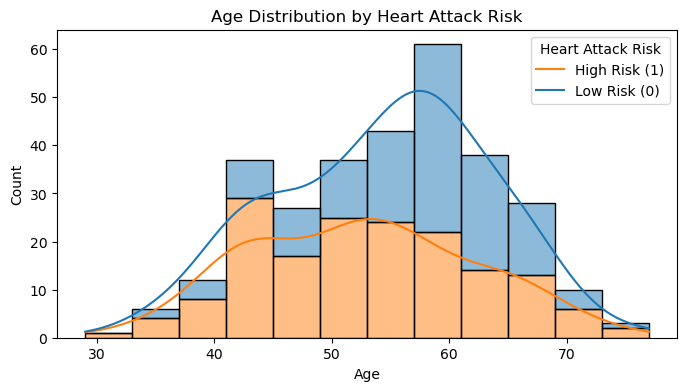

In [87]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='age', hue='output', kde=True, multiple='stack')
plt.title('Age Distribution by Heart Attack Risk')
plt.xlabel('Age')
plt.legend(title='Heart Attack Risk', labels=['High Risk (1)', 'Low Risk (0)'])
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

بر خلاف تصور رایج که فکر می کنیم ریسک حمله قلبی با افزایش سن بالا میره ولی این نمودار نشون میده این ریسک در میانسالی بیشتره و از 40 سال شروع میشه
و از 60 سال به بعد ریسک به طور معنی داری کاهش پیدا کرده.
</div>

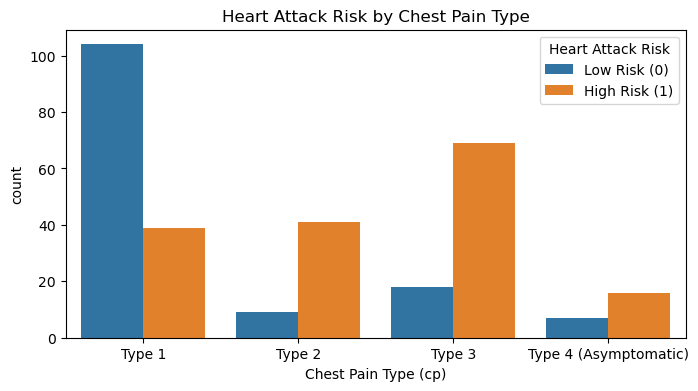

In [88]:
plt.figure(figsize=(8,4))
sns.countplot(data=df , x = 'cp' , hue = 'output')
plt.title('Heart Attack Risk by Chest Pain Type')
plt.xlabel('Chest Pain Type (cp)')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Type 1', 'Type 2', 'Type 3', 'Type 4 (Asymptomatic)'])
plt.legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

- نوع ۱ : درد مستقیم قلبی 
- نوع ۲ : درد غیرمسقیم که منجر به حس کردن درد در قلب میشود
- نوع ۳ : درد غیر قلبی
- نوع ۴ : بدون علایم
</div>

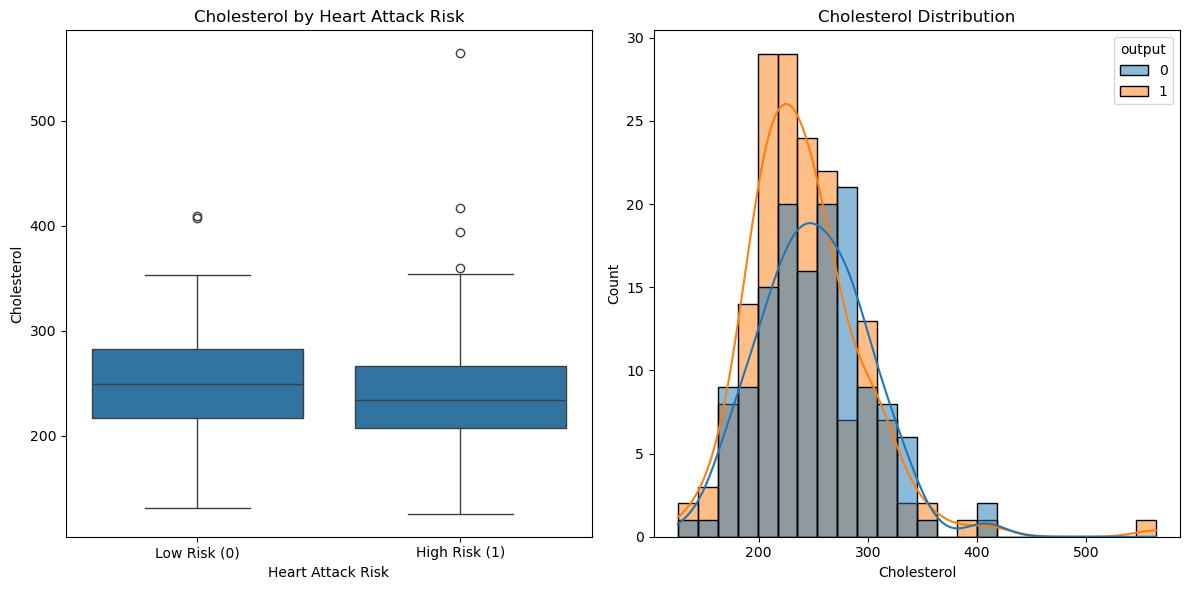

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='output', y='chol', data=df, ax=axes[0])
axes[0].set_title('Cholesterol by Heart Attack Risk')
axes[0].set_xlabel('Heart Attack Risk')
axes[0].set_ylabel('Cholesterol')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Low Risk (0)', 'High Risk (1)'])
sns.histplot(data=df, x='chol', hue='output', kde=True, ax=axes[1])
axes[1].set_title('Cholesterol Distribution')
axes[1].set_xlabel('Cholesterol')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

- شباهت غیرمنتظره توزیع های هردو گروه نشان دهنده این است که میزان کلسترول به تنهایی در تشخیص ریسک کمکی نمی کند.
- ولی در دنیای پزشکی یکی از عوامل مهم است. درهرصورت احتمالا مدل به این فیچر وزن کمی خواهد داد.
</div>

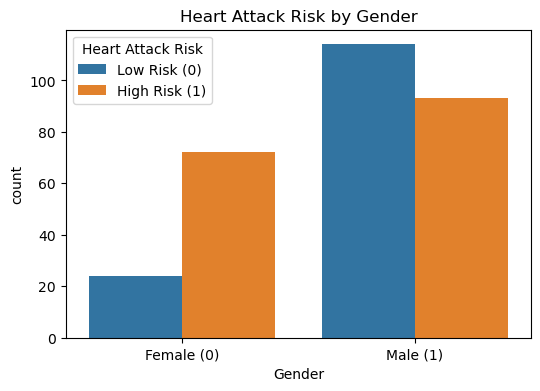

In [90]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df, hue='output')
plt.title('Heart Attack Risk by Gender')
plt.xlabel('Gender')
plt.xticks(ticks=[0, 1], labels=['Female (0)', 'Male (1)'])
plt.legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

- نمودار نشون میده ریسک حمله قلبی زنان بیشتره که این فیچر هم میتونی وزن خوبی در مدل بگیره
</div>

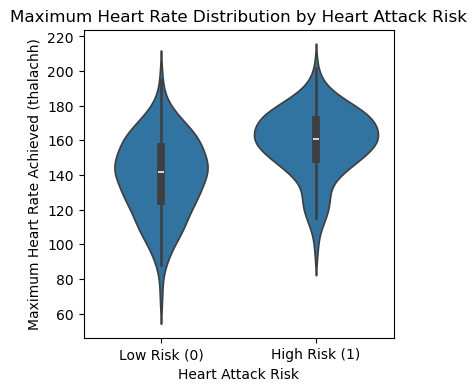

In [91]:
plt.figure(figsize=(4, 4))
sns.violinplot(x='output', y='thalachh', data=df)
plt.title('Maximum Heart Rate Distribution by Heart Attack Risk')
plt.xlabel('Heart Attack Risk')
plt.ylabel('Maximum Heart Rate Achieved (thalachh)')
plt.xticks(ticks=[0, 1], labels=['Low Risk (0)', 'High Risk (1)'])
plt.show()

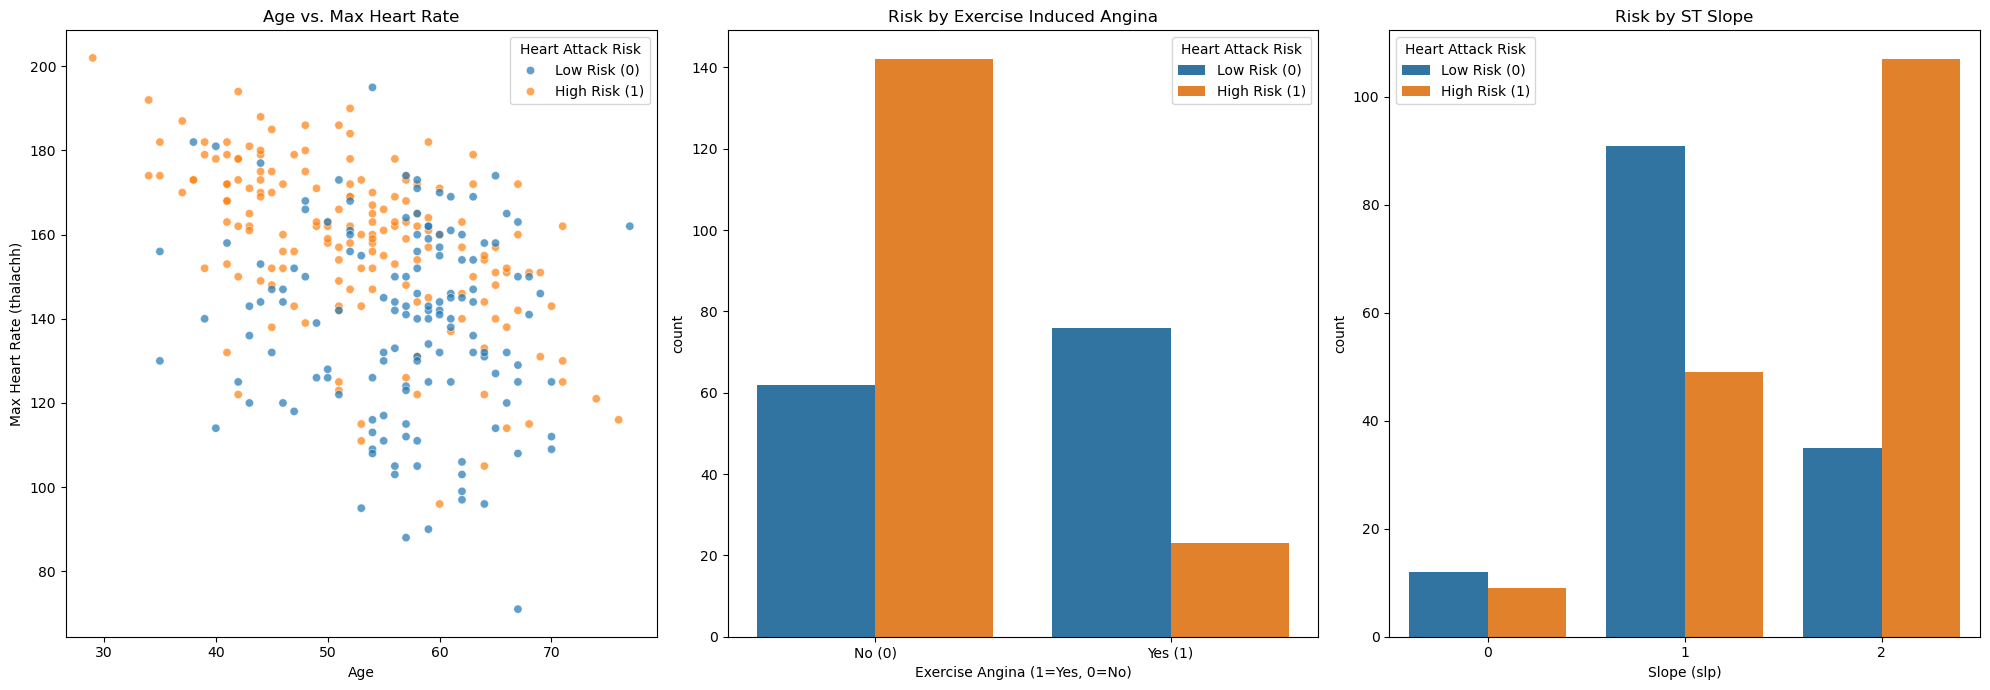

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axes[0], x='age', y='thalachh', data=df, hue='output', alpha=0.7)
axes[0].set_title('Age vs. Max Heart Rate')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Max Heart Rate (thalachh)')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Low Risk (0)', 'High Risk (1)'], title='Heart Attack Risk')
sns.countplot(ax=axes[1], x='exng', data=df, hue='output')
axes[1].set_title('Risk by Exercise Induced Angina')
axes[1].set_xlabel('Exercise Angina (1=Yes, 0=No)')
axes[1].set_xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'])
axes[1].legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])
sns.countplot(ax=axes[2], x='slp', data=df, hue='output')
axes[2].set_title('Risk by ST Slope')
axes[2].set_xlabel('Slope (slp)')
axes[2].legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])
plt.tight_layout()
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

- نمودار وسط ریسک حمله رو در گروهی که درد ناشی از ورزش داشتن بسیار کمتر از گروهی ست که این درد رو نداشتن که به شخصه تحلیل من اینه که در گروه 
دوم(No) تعداد ورزش کاران هم کمتر بوده و درد هم نداشتن به همین سبب ریسک حمله در این گروه بیشتر شده.
- در نمودار سمت راست هم گروه 2 (گروهی که بطن چپ قلب یزرگ شده) تشخیص راحت و و واضح هست و این فیچر هم به مدل کمک زیادی خواهد کرد.

</div>

C:\Users\Doust\AppData\Local\Temp\ipykernel_36124\2852236667.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Low Risk (0)', 'High Risk (1)'])


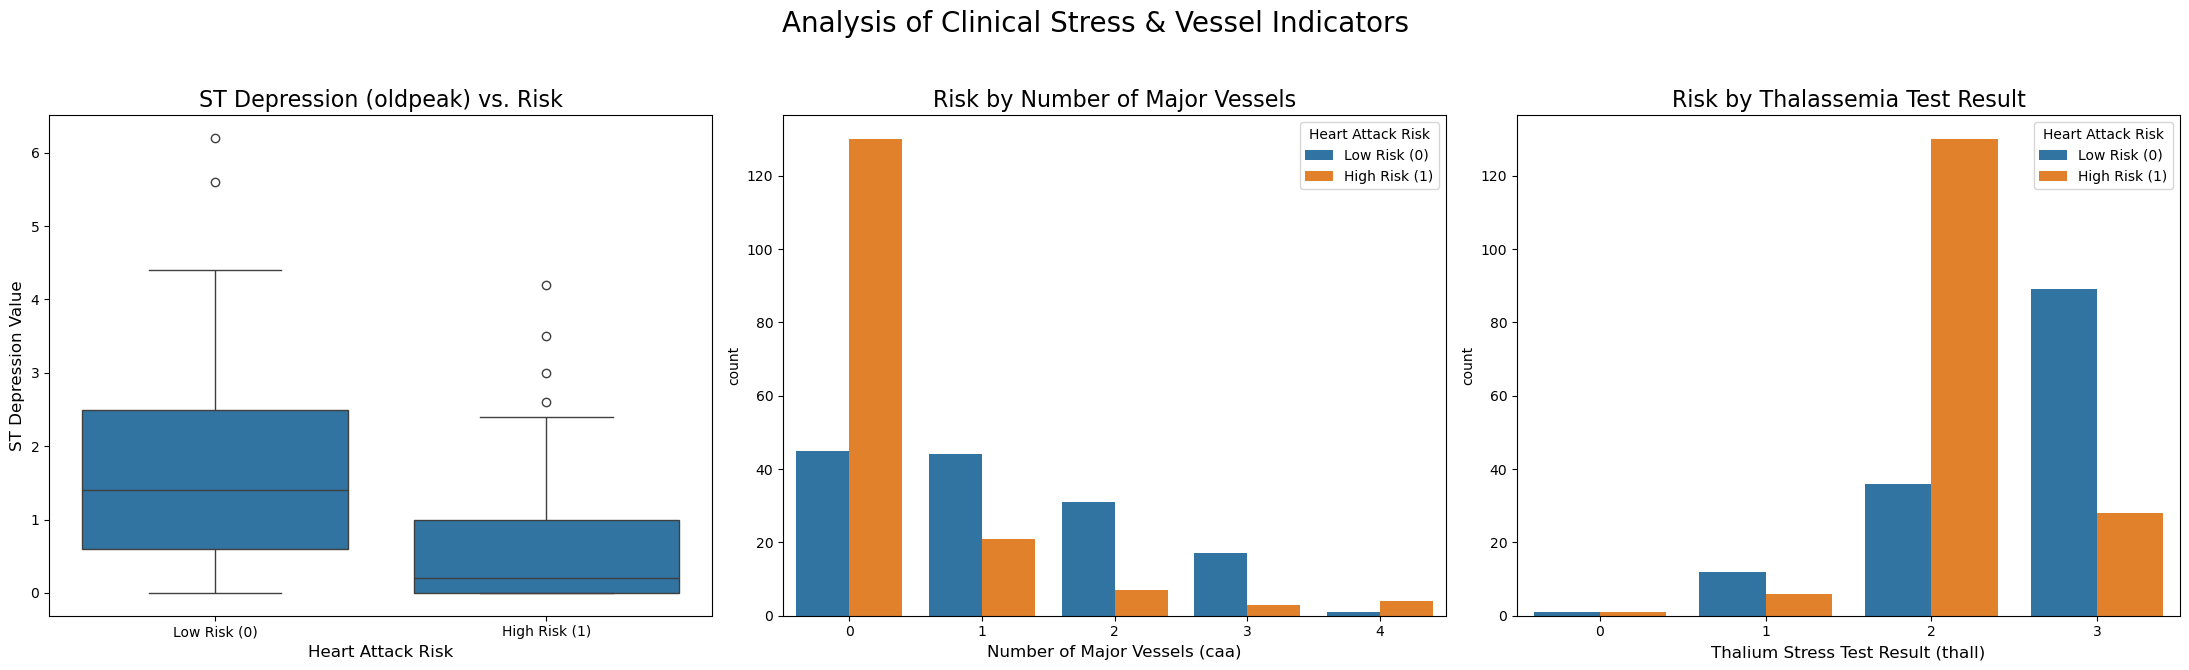

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Analysis of Clinical Stress & Vessel Indicators', fontsize=20)

sns.boxplot(ax=axes[0], x='output', y='oldpeak', data=df)
axes[0].set_title('ST Depression (oldpeak) vs. Risk', fontsize=16)
axes[0].set_xlabel('Heart Attack Risk', fontsize=12)
axes[0].set_ylabel('ST Depression Value', fontsize=12)
axes[0].set_xticklabels(['Low Risk (0)', 'High Risk (1)'])

sns.countplot(ax=axes[1], x='caa', data=df, hue='output')
axes[1].set_title('Risk by Number of Major Vessels', fontsize=16)
axes[1].set_xlabel('Number of Major Vessels (caa)', fontsize=12)
axes[1].legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])

sns.countplot(ax=axes[2], x='thall', data=df, hue='output')
axes[2].set_title('Risk by Thalassemia Test Result', fontsize=16)
axes[2].set_xlabel('Thalium Stress Test Result (thall)', fontsize=12)
axes[2].legend(title='Heart Attack Risk', labels=['Low Risk (0)', 'High Risk (1)'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<div dir="rtl" style="font-family: Tahoma; font-size: 15px; line-height: 1.8;">

تحلیل هوش مصنوعی :
# ۱. اثر ترکیبی caa و thall (تنگی عروق و نقص پرفیوژن)
مشاهده: در نمودار دوم (caa)، با افزایش تعداد رگ‌های اصلی درگیر (از ۰ به سمت ۳)، جمعیت بیماران با ریسک بالا (نارنجی) به شدت کاهش می‌یابد و تقریباً ناپدید می‌شود. در نمودار سوم (thall)، بیماران با نتیجه تست تالیم نوع ۲ (نقص برگشت‌پذیر) به طور عمده در گروه ریسک بالا (نارنجی) قرار دارند.

استنتاج عمیق: این دو نمودار در کنار هم یک داستان را بیان می‌کنند: مشکل اصلی در بیماران پرخطر، لزوماً تعداد رگ‌های مسدود شده نیست، بلکه کیفیت جریان خون در عضله قلب است. یک بیمار ممکن است تعداد رگ‌های درگیر کمی داشته باشد (caa=0)، اما اگر همان رگ‌ها دچار نقص پرفیوژن برگشت‌پذیر (thall=2) باشند، این فرد در گروه پرخطر قرار می‌گیرد. این نشان می‌دهد که thall احتمالاً یک ویژگی بسیار قدرتمندتر از caa است، زیرا به جای آناتومی، بر عملکرد تمرکز دارد.

# ۲. نقش oldpeak (افتادگی قطعه ST)
مشاهده: نمودار اول (oldpeak) نشان می‌دهد که بیماران با ریسک پایین (آبی) مقادیر oldpeak بسیار بالاتری را (حتی تا بالای ۶) تجربه می‌کنند، در حالی که مقادیر oldpeak برای گروه پرخطر (نارنجی) به ندرت از ۳ بالاتر می‌رود و میانه آن نزدیک به صفر است.

استنتاج عمیق: این نتیجه در نگاه اول کاملاً غیرمنتظره است، زیرا در پزشکی، افتادگی قطعه ST (oldpeak بالا) یک نشانه ایسکمی و خطر است. اما این نمودار، در ترکیب با دو نمودار دیگر، می‌تواند این‌گونه تفسیر شود: بیمارانی که قلبشان توانایی ایجاد یک پاسخ الکتریکی شدید به استرس (oldpeak بالا) را دارد، در واقع ذخیره قلبی بهتری داشته و در گروه ریسک پایین قرار می‌گیرند. در مقابل، بیمارانی که حتی با استرس، قلبشان پاسخ الکتریکی ضعیفی می‌دهد (oldpeak پایین)، ممکن است دچار یک مشکل عملکردی جدی‌تر (که با thall=2 مشخص می‌شود) باشند و در نتیجه در گروه ریسک بالا قرار بگیرند.
</div>

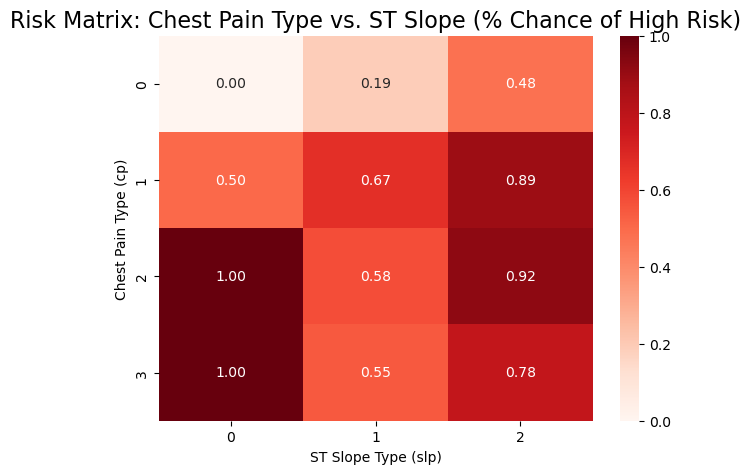

In [94]:
risk_matrix = df.pivot_table(values='output', index='cp', columns='slp')
plt.figure(figsize=(7, 5))
sns.heatmap(risk_matrix, annot=True, cmap='Reds', fmt='.2f')
plt.title('Risk Matrix: Chest Pain Type vs. ST Slope (% Chance of High Risk)', fontsize=16)
plt.xlabel('ST Slope Type (slp)')
plt.ylabel('Chest Pain Type (cp)')
plt.show()



# 3. Model Training

### CatBoost

In [95]:
X = np.asanyarray(df.drop(columns='output',axis=1))
Y = np.asanyarray(df.output)
x_train , x_test ,y_train , y_test = train_test_split(X,Y,test_size=0.25 , random_state=42)

In [96]:
model_CB = CatBoostClassifier()
model_CB.fit(x_train,y_train)

Learning rate set to 0.00547
0:	learn: 0.6882407	total: 2.18ms	remaining: 2.18s
1:	learn: 0.6840606	total: 3.91ms	remaining: 1.95s
2:	learn: 0.6801035	total: 5.44ms	remaining: 1.81s
3:	learn: 0.6758062	total: 6.99ms	remaining: 1.74s
4:	learn: 0.6717442	total: 8.37ms	remaining: 1.67s
5:	learn: 0.6671794	total: 9.63ms	remaining: 1.59s
6:	learn: 0.6641249	total: 10.7ms	remaining: 1.52s
7:	learn: 0.6603131	total: 11.7ms	remaining: 1.45s
8:	learn: 0.6561870	total: 12.9ms	remaining: 1.42s
9:	learn: 0.6524910	total: 14.3ms	remaining: 1.42s
10:	learn: 0.6480964	total: 15.4ms	remaining: 1.39s
11:	learn: 0.6445001	total: 16.7ms	remaining: 1.38s
12:	learn: 0.6405990	total: 17.7ms	remaining: 1.34s
13:	learn: 0.6369423	total: 18.6ms	remaining: 1.31s
14:	learn: 0.6328240	total: 19.7ms	remaining: 1.29s
15:	learn: 0.6285960	total: 20.9ms	remaining: 1.28s
16:	learn: 0.6241533	total: 22ms	remaining: 1.27s
17:	learn: 0.6199704	total: 23.1ms	remaining: 1.26s
18:	learn: 0.6160648	total: 24.2ms	remaining: 1

In [ ]:
y_hat_xg = model_CB.predict(x_test)
print(f'classification_report : \n {classification_report(y_test,y_hat_xg)}')
print(f'confusion_matrix: \n {confusion_matrix(y_test,y_hat_xg)}')

classification_report : 
               precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.81      0.85      0.83        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76

confusion_matrix: 
 [[27  8]
 [ 6 35]]


### XGboost

In [98]:
model_xg = xg.XGBClassifier()
model_xg.fit(x_train,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [99]:
y_hat_xg = model_xg.predict(x_test)
print(f'classification_report : \n {classification_report(y_test,y_hat_xg)}')
print(f'confusion_matrix: \n {confusion_matrix(y_test,y_hat_xg)}')

classification_report : 
               precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.81      0.85      0.83        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76

confusion_matrix: 
 [[27  8]
 [ 6 35]]
